In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.stem as PorterStemmer

In [63]:
df=pd.read_csv("QuoraQuestionPairs_train.csv")

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [65]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<AxesSubplot:xlabel='is_duplicate'>

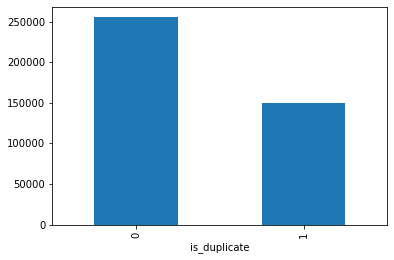

In [66]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [67]:
print("Question pairs are not similar(is_duplicate=0):\n{}%".format(round(100-df['is_duplicate'].mean()*100,2)))
print("Question pairs are  similar(is_duplicate=1):\n{}%".format(round(df['is_duplicate'].mean()*100,2)))

Question pairs are not similar(is_duplicate=0):
63.08%
Question pairs are  similar(is_duplicate=1):
36.92%


In [68]:
qids=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
unique_ques=len(np.unique(qids))
print("Total number of Unique Questions: {}".format(unique_ques))
ques_morethan_onetime = np.sum(qids.value_counts()>1)
print("Total number of Unique Questions that appear more than one time: {} ({}%)".format(ques_morethan_onetime,ques_morethan_onetime/unique_ques*100)) 
print("Max number of times a single question is repeated: {}".format(max(qids.value_counts())))

Total number of Unique Questions: 537933
Total number of Unique Questions that appear more than one time: 111780 (20.77953945937505%)
Max number of times a single question is repeated: 157


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


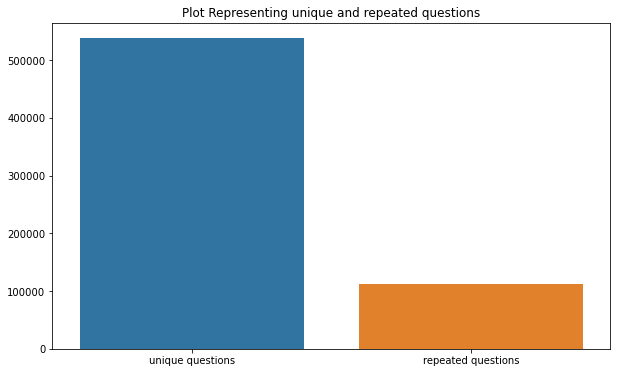

In [69]:
x=["unique questions","repeated questions"]
y=[unique_ques,ques_morethan_onetime]
plt.figure(figsize=(10,6))
plt.title("Plot Representing unique and repeated questions")
sns.barplot(x,y)
plt.show()

In [70]:
#Checking Number of duplicate Pairs
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Total number of Duplicate Pairs: {}".format(pair_duplicates.shape[0]-df.shape[0]))

Total number of Duplicate Pairs: 0


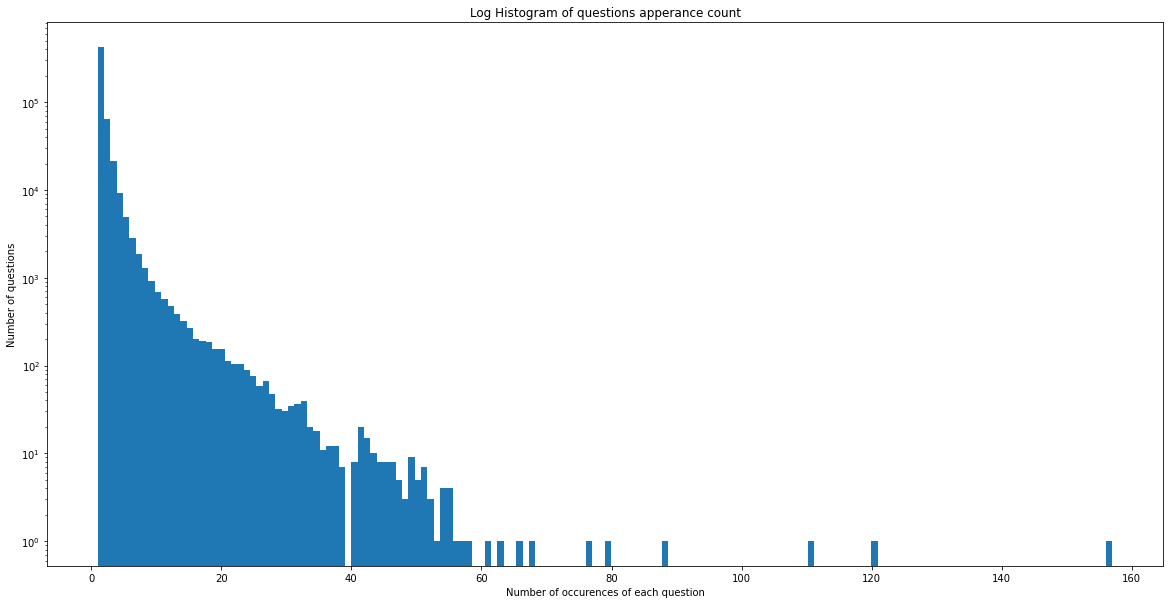

In [71]:
plt.figure(figsize=(20,10))
plt.title("Log Histogram of questions apperance count")
plt.hist(qids.value_counts(),bins=160)
plt.xlabel("Number of occurences of each question")
plt.ylabel("Number of questions")
plt.yscale('log')

In [72]:
#Checking for NULL values
nan = df[df.isnull().any(1)]
print(nan)
print(len(nan))

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  
3


In [73]:
df=df.fillna(" ")
nan=df[df.isnull().any(1)]
print(len(nan))


0


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [74]:
df.shape
import os

In [88]:
if os.path.isfile('QuoraQuestionPairs_trainPart1.csv'):
    df=pd.read_csv('QuoraQuestionPairs_trainPart1.csv')
else:
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    df['q1len']=df['question1'].str.len()
    df['q2len']=df['question2'].str.len()
    df['q1_n_words']= df['question1'].apply(lambda row:len(row.split(" ")))
    df['q2_n_words']= df['question2'].apply(lambda row:len(row.split(" ")))
    def normalized_word_common(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0*len(w1&w2)
    df['word_common']=df.apply(normalized_word_common,axis=1)
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])
    df.to_csv('QuoraQuestionPairs_trainPart1.csv')
    
                
df.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


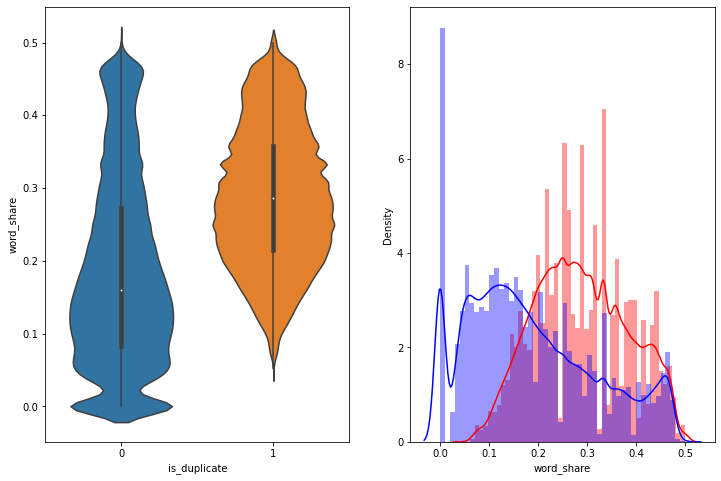

In [97]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate",y="word_share",data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"]==1.0]['word_share'][0:],label="1",color='red')
sns.distplot(df[df["is_duplicate"]==0.0]['word_share'][0:],label="0",color="blue")
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


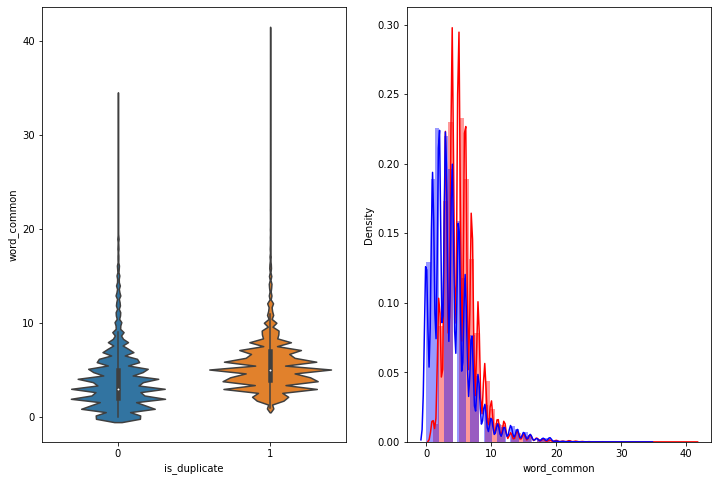

In [98]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate",y="word_common",data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"]==1.0]['word_common'][0:],label="1",color='red')
sns.distplot(df[df["is_duplicate"]==0.0]['word_common'][0:],label="0",color="blue")
plt.show()